# IMPORTS

In [2]:
## Work with arrays
import numpy as np
## Make figures
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import matplotlib.ticker as mticker
## Draw maps
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.ticker import LatitudeLocator, LongitudeLocator
# Open netCDF-files
import netCDF4 as nc
# Manipulate data-frames
import pandas as pd
# Manipulate dates
import datetime as dt
from dateutil.relativedelta import relativedelta

from data_path import DATA_PATH_SROK8C

# CATALOG

In [31]:
stations = pd.read_csv(DATA_PATH_SROK8C+"../catalog.csv")
stations

,Индекс ВМО,Наименование станции,Широта,Долгота,Высота,Начало наблюдений,Примечание
0,20046,Им.Э.Т.Кренкеля,80°37',58°03',21,1966,NaN
1,20069,Остров Визе,79°30',76°59',12,1966,NaN
2,20087,Им.Г.А.Ушакова (Голомянный),79°33',90°37',7,1966,До 2015г. наз. Остров Голомянный
3,20107,Баренцбург,78°04',14°15',73,1966,NaN
4,20289,Русский,77°10',96°26',9,1966,Закрыта в 1999г.
...,...,...,...,...,...,...,...
516,37461,"Сулак, высокогорная",42°22',46°15',2927,1966,NaN
517,37470,Дербент,42°04',48°18',-19,1966,NaN
518,37471,Буйнакск,42°49',47°07',472,1966,NaN
519,37472,Махачкала,43°01',47°29',-20,1966,"С 1966г. по 11.1991г. – Махачкала,АЭ, ЮВ окраи..."


In [4]:
def converter(geoCoord: str):
    delimiter = geoCoord.find("°")
    if delimiter == -1:
        delimiter = geoCoord.find("о")
    if delimiter == -1:
        delimiter = geoCoord.find("o")
    return float(geoCoord[:delimiter]) + float(geoCoord[delimiter+1:delimiter+3])/60

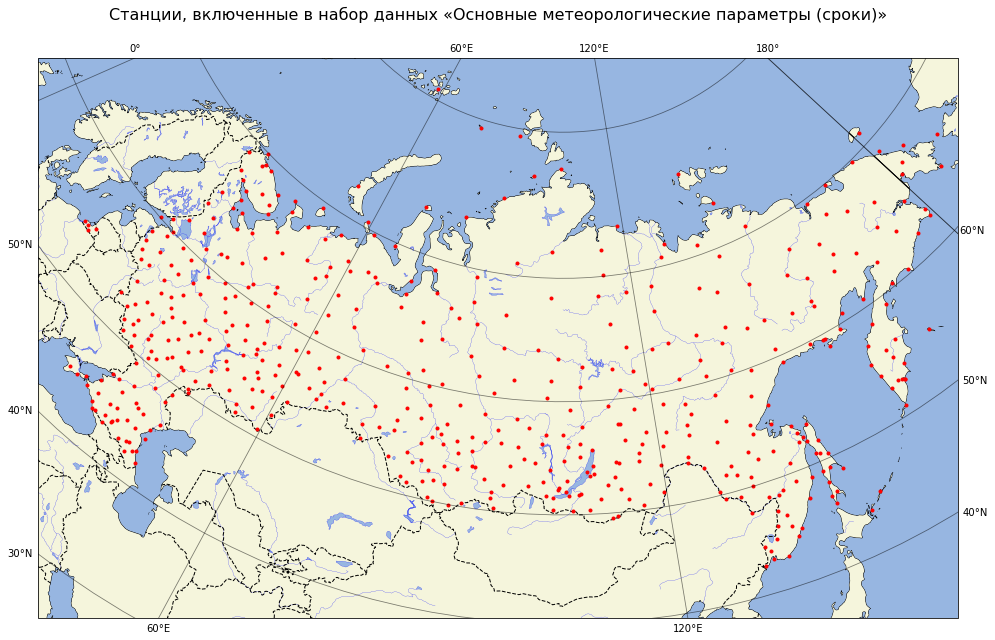

In [18]:
locs = np.empty((520,2))
for i in range(520):
    locs[i,0] = converter(stations["Широта"][i])
    locs[i,1] = converter(stations["Долгота"][i])   

fig = plt.figure(figsize=(16,9), layout='tight')
lambert_crs = ccrs.LambertConformal(central_longitude=105) 
ax = fig.add_subplot(1,1,1,
                     projection=lambert_crs
                    )
ax.set_extent(
    [35, 155, 40, 80], 
    crs=ccrs.PlateCarree()
)
gl = ax.gridlines(
    draw_labels=True, 
    dms=True, 
    x_inline=False,
    y_inline=False,
    alpha=0.5,
    color='k'
)
gl.rotate_labels = False
# ax.coastlines(resolution='100m')
for loc in locs:
    plt.plot(
        loc[1], loc[0], 
        transform=ccrs.PlateCarree(),
        marker='.', color='red'
    )

resol = '50m'  # use data at this scale
bodr = cf.NaturalEarthFeature(category='cultural', 
    name='admin_0_boundary_lines_land', scale=resol, facecolor='none', alpha=0.7)
land = cf.NaturalEarthFeature('physical', 'land', \
    scale=resol, edgecolor='k', facecolor=cf.COLORS['land'])
ocean = cf.NaturalEarthFeature('physical', 'ocean', \
    scale=resol, edgecolor='none', facecolor=cf.COLORS['water'])
lakes = cf.NaturalEarthFeature('physical', 'lakes', \
    scale=resol, edgecolor='b', facecolor=cf.COLORS['water'])
rivers = cf.NaturalEarthFeature('physical', 'rivers_lake_centerlines', \
    scale=resol, edgecolor='b', facecolor='none')

ax.add_feature(land, facecolor='beige')
ax.add_feature(ocean, linewidth=0.2 )
ax.add_feature(lakes, linewidth=0.2)
ax.add_feature(rivers, linewidth=0.2)
ax.add_feature(bodr, linestyle='--', edgecolor='k', alpha=1)

ax.set_title("Станции, включенные в набор данных «Основные метеорологические параметры (сроки)»\n", fontsize=16)
fig.savefig("rihmi_wdc_stations.png", dpi=250)

# METEOROLOGICAL CHARACTERISTICS

In [51]:
VALID_QUALITIES = [0, 1, 2]
FILL_VALUE_FLOAT = -999.0
FILL_VALUE_INT = -999

def forcingAndValidDF(stationID: int):
    
    forcing = {
        "GMT datetime" : list(),
        # "Total cloudiness (points)" : list(),
        # "Cloud ceiling (m)" : list(),
        "Wind speed (m/s)" : list(),
        "Precipitation rate (mm/s)" : list(),
        "Dry-bulb thermometer air temperature (°C)" : list(),
        "Relative air humidity (%)" : list(),
        "Air pressure at station level (mbar)" : list()
    }
    
    validation = {
        "GMT datetime" : list(),
        "Soil surface temperature (°C)" : list()
    }
    
    precip_tot = list()
    
    with open(
        DATA_PATH_SROK8C
        + f"{stationID}.dat"
    ) as f:
        for line in f:
            
            datetime_ = dt.datetime(
                int(line[6:10]), 
                int(line[11:13]), 
                int(line[14:16]),
                int(line[17:19])
            )
            
            forcing["GMT datetime"] += [datetime_]
            
            # code = line[53:55]
            # quality = int(line[56:57])
            # forcing["Total cloudiness (points)"] += [cldnssInPoints(code, quality)]
            
            # code = line[88:92]
            # quality = int(line[93:94])
            # method = line[95:96]
            # forcing["Cloud ceiling (m)"] += [cldClng(code, quality, method)]
            
            code = line[118:120]
            quality = int(line[121:122])
            idGT = line[123:124]
            forcing["Wind speed (m/s)"] += [windSpd(code, quality, idGT)]
            
            code = line[132:138]
            quality = int(line[139:140])
            precip_tot += [precip(code, quality)]
            
            code = line[181:186]
            quality = int(line[187:188])
            forcing["Dry-bulb thermometer air temperature (°C)"] += [
                temp(code, quality)
            ]
            
            code = line[241:244]
            quality = int(line[245:246])
            forcing["Relative air humidity (%)"] += [rh(code, quality)]
            
            code = line[267:273]
            quality = int(line[274:275])
            prec = "1"
            forcing["Air pressure at station level (mbar)"] += [prs(code, quality, prec)]
            
            validation["GMT datetime"] += [datetime_]
            
            code = line[141:146]
            quality = int(line[147:148])
            validation["Soil surface temperature (°C)"] += [temp(code, quality)]
            
    forcing['Precipitation rate (mm/s)'] = list(
        precipRate(precip_tot) / (3 * 3600)
    )
    
    forcing_df = pd.DataFrame(data=forcing)
    validation_df = pd.DataFrame(data=validation)
    
    return forcing_df, validation_df

def precipRate(a):
    FILL_VALUE = -999.0
    res = np.zeros_like(a)
    i0 = 0
    i1 = i0 + 1
    for i, aa in enumerate(a[1:]):
        if aa == FILL_VALUE:
            i1 += 1
        else:
            res[i0:i1] = aa / (i1 - i0)
            i0 = i
            i1 = i0 + 1
    return res

def rh(code: str, quality: int) -> float:
    res = -999.0
    if quality in VALID_QUALITIES:
        res = float(code)
    return res
            
def prs(code: str, quality: int, prec: str) -> float:
    res = -999.0
    if quality in VALID_QUALITIES:
        res = float(code)
        if prec == "1":
            res = np.round(res, -1)
        if prec == "2":
            res = np.round(res, -2)
    return res

def temp(code: str, quality: int) -> float:
    res = -999.0
    if quality in VALID_QUALITIES:
        res = float(code)
    return res            
            
def precip(code: str, quality: int) -> float:
    res = -999.0
    if quality in VALID_QUALITIES:
        res = float(code)
    return res

def windSpd(code: str, quality: int, idGT: str) -> float:
    res = -999.0
    if quality in VALID_QUALITIES and idGT == "0":
        res = float(code)
    return res

def cldnssInPoints(code: str, quality: int) -> float:
    CLDNSS_11 = -999.0 #11
    CLDNSS_12 = -999.0 #12
    CLDNSS_13 = -999.0 #13
    res = -999.0
    if quality in VALID_QUALITIES and code != "99":
        if code == "11":
            res = CLDNSS_11
        elif code == "12":
            res = CLDNSS_12
        elif code == "13":
            res = CLDNSS_13
        else:
            res = float(code)
    return res        

def cldClng(code: str, quality: int, method: str) -> float:
    res = -999.0
    if quality in VALID_QUALITIES and code != "    ":
        res = float(code)
    return res

def genCodes(start, end):
    res = list()
    if end > 99:
        return -999.0
    for i in range(start, end):
        if i < 10:
            res += [f"0{i}"]
        else:
            res += [f"{i}"]
    return res

In [52]:
a, b = forcingAndValidDF(20046)

In [61]:
a[a['Wind speed (m/s)'] == -999.0]

,GMT datetime,Wind speed (m/s),Precipitation rate (mm/s),Dry-bulb thermometer air temperature (°C),Relative air humidity (%),Air pressure at station level (mbar)
6460,1968-03-18 06:00:00,-999.0,3.858025e-07,-28.9,93.0,1000.0
6532,1968-03-27 06:00:00,-999.0,2.160494e-05,-999.0,-999.0,-999.0
6548,1968-03-29 06:00:00,-999.0,3.086420e-07,-999.0,-999.0,-999.0
7092,1968-06-05 06:00:00,-999.0,0.000000e+00,-999.0,-999.0,-999.0
7107,1968-06-07 03:00:00,-999.0,0.000000e+00,-999.0,-999.0,-999.0
...,...,...,...,...,...,...
166547,2022-12-31 03:00:00,-999.0,0.000000e+00,-999.0,-999.0,-999.0
166548,2022-12-31 06:00:00,-999.0,0.000000e+00,-999.0,-999.0,-999.0
166549,2022-12-31 09:00:00,-999.0,0.000000e+00,-999.0,-999.0,-999.0
166550,2022-12-31 12:00:00,-999.0,0.000000e+00,-999.0,-999.0,-999.0


0